In [1]:
from collections import Counter
import nltk
import string
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from avaml import download
from avaml import Error, varsomdata, setenvironment as se, _NONE, CSV_VERSION, REGIONS, merge
from avaml.get_text_data import TextDataset
from avaml.aggregatedata import ForecastDataset, LabeledData, REG_ENG, CsvMissingError

Varsom data has class in API, class Avalanche Warning, main message is text
https://github.com/NVE/varsomdata/blob/471a0e368e3f69352f27d73cb19ce8efa82d9467/varsomdata/getforecastapi.py

In [2]:
model_prefix = ''
days = 1
regobs_types = list(REG_ENG.keys())
text_data = TextDataset(regobs_types=regobs_types).label(days, with_varsom=True)

Fetching online data. (This may take a long time.)
    Getting data for season: 2017-18
    Getting data for season: 2018-19
    Getting data for season: 2019-20
Done!

Creating labeled dataset.
Done!


In [3]:
# first, drop regions
text_data = text_data.drop_regions()

# then, rename indices
text_data.data = text_data.data.rename_axis(['date','region'])
text_data.label = text_data.label.rename_axis(['date', 'region'])
text_data.main_text = text_data.main_text.rename_axis(['date', 'region'])

# flatten the hierchy of columns to 1D
text_data.data.columns = [' '.join(col).strip().replace(' ', '_') for col in text_data.data.columns.values]
text_data.label.columns = [' '.join(col).strip().replace(' ', '_') for col in text_data.label.columns.values]

# replace double underscores with single underscores
text_data.data.columns = [col.replace('__', '_') for col in text_data.data.columns.values]
text_data.label.columns = [col.replace('__', '_') for col in text_data.label.columns.values]

# convert some columns in labels to type int for averaging
text_data.label['CLASS_problem_amount'] = text_data.label['CLASS_problem_amount'].astype(int)
text_data.label['CLASS_danger_level'] = text_data.label['CLASS_danger_level'].astype(int)

for column in text_data.label.columns:
    if column.endswith(('_dist', '_dsize', '_lev_fill', '_prob', '_trig')):
        text_data.label[column] = text_data.label[column].astype(int)
        
# below, we can try to make categorical variables in the labels numeric
# first for the emergency warning column
warning_dict = {'Ikke gitt':0,
                'Naturlig utløste skred':1}

text_data.label['CLASS_emergency_warning'] = text_data.label['CLASS_emergency_warning'].replace(warning_dict)

# and now for the class problems
problem1 = list(np.unique(text_data.label.loc[:, 'CLASS_problem_1'].values))
problem2 = list(np.unique(text_data.label.loc[:, 'CLASS_problem_2'].values))
problem3 = list(np.unique(text_data.label.loc[:, 'CLASS_problem_3'].values))

list_of_problems = sorted(list(np.unique(problem1 + problem2 + problem3)))
problems_dict = {'':0, 'drift-slab':1, 'glide':2, 'new-loose':3,
                 'new-slab':4, 'pwl-slab':5, 'wet-loose':6, 'wet-slab':7}

text_data.label['CLASS_problem_1'] = text_data.label['CLASS_problem_1'].replace(problems_dict)
text_data.label['CLASS_problem_2'] = text_data.label['CLASS_problem_2'].replace(problems_dict)
text_data.label['CLASS_problem_3'] = text_data.label['CLASS_problem_3'].replace(problems_dict)

text_data.data = text_data.data.reorder_levels([1, 0])
text_data.label = text_data.label.reorder_levels([1, 0])
text_data.main_text = text_data.main_text.reorder_levels([1, 0])

In [4]:
data = text_data.data
labels = text_data.label
main_text = text_data.main_text

In [5]:
data

,,danger_level_1,emergency_warning_1,problem_amount_1,problem_new-loose_1,problem_wet-loose_1,problem_new-slab_1,problem_drift-slab_1,problem_pwl-slab_1,problem_wet-slab_1,problem_glide_1,...,wind_chg_dir_W_0,wind_chg_dir_NW_0,wind_chg_start_0_0,wind_chg_start_6_0,wind_chg_start_12_0,wind_chg_start_18_0,temp_fl_start_0_0,temp_fl_start_6_0,temp_fl_start_12_0,temp_fl_start_18_0
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-23,4.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3034,2017-11-23,4.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3003,2017-12-02,1.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-12-02,2.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3009,2017-12-02,2.0,1.0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,3.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3032,2021-01-12,3.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2021-01-12,3.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.columns

Index(['danger_level_1', 'emergency_warning_1', 'problem_amount_1',
       'problem_new-loose_1', 'problem_wet-loose_1', 'problem_new-slab_1',
       'problem_drift-slab_1', 'problem_pwl-slab_1', 'problem_wet-slab_1',
       'problem_glide_1',
       ...
       'wind_chg_dir_W_0', 'wind_chg_dir_NW_0', 'wind_chg_start_0_0',
       'wind_chg_start_6_0', 'wind_chg_start_12_0', 'wind_chg_start_18_0',
       'temp_fl_start_0_0', 'temp_fl_start_6_0', 'temp_fl_start_12_0',
       'temp_fl_start_18_0'],
      dtype='object', length=245)

In [7]:
labels

,,CLASS_danger_level,CLASS_emergency_warning,CLASS_problem_1,CLASS_problem_2,CLASS_problem_3,CLASS_problem_amount,CLASS_drift-slab_cause,CLASS_drift-slab_dist,CLASS_drift-slab_dsize,CLASS_drift-slab_lev_fill,...,REAL_new-loose_lev_max,REAL_new-loose_lev_min,REAL_new-slab_lev_max,REAL_new-slab_lev_min,REAL_pwl-slab_lev_max,REAL_pwl-slab_lev_min,REAL_wet-loose_lev_max,REAL_wet-loose_lev_min,REAL_wet-slab_lev_max,REAL_wet-slab_lev_min
region,date,,,,,,,,,,,,,,,,,,,,,
3031,2017-11-23,4,0,1,0,0,1,snowdrift,3,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3034,2017-11-23,4,0,1,0,0,1,snowdrift,3,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3003,2017-12-02,1,0,1,0,0,1,snowdrift,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3007,2017-12-02,2,0,5,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,400.0,0.0,0.0,0.0,0.0,0.0
3009,2017-12-02,2,0,5,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,400.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3031,2021-01-12,3,0,5,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,600.0,600.0,0.0,0.0,0.0,0.0
3032,2021-01-12,3,0,5,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,800.0,800.0,0.0,0.0,0.0,0.0
3034,2021-01-12,3,0,5,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,600.0,600.0,0.0,0.0,0.0,0.0


In [8]:
labels.columns

Index(['CLASS_danger_level', 'CLASS_emergency_warning', 'CLASS_problem_1',
       'CLASS_problem_2', 'CLASS_problem_3', 'CLASS_problem_amount',
       'CLASS_drift-slab_cause', 'CLASS_drift-slab_dist',
       'CLASS_drift-slab_dsize', 'CLASS_drift-slab_lev_fill',
       'CLASS_drift-slab_prob', 'CLASS_drift-slab_trig', 'CLASS_glide_cause',
       'CLASS_glide_dist', 'CLASS_glide_dsize', 'CLASS_glide_lev_fill',
       'CLASS_glide_prob', 'CLASS_glide_trig', 'CLASS_new-loose_cause',
       'CLASS_new-loose_dist', 'CLASS_new-loose_dsize',
       'CLASS_new-loose_lev_fill', 'CLASS_new-loose_prob',
       'CLASS_new-loose_trig', 'CLASS_new-slab_cause', 'CLASS_new-slab_dist',
       'CLASS_new-slab_dsize', 'CLASS_new-slab_lev_fill',
       'CLASS_new-slab_prob', 'CLASS_new-slab_trig', 'CLASS_pwl-slab_cause',
       'CLASS_pwl-slab_dist', 'CLASS_pwl-slab_dsize',
       'CLASS_pwl-slab_lev_fill', 'CLASS_pwl-slab_prob', 'CLASS_pwl-slab_trig',
       'CLASS_wet-loose_cause', 'CLASS_wet-loose_dis

In [9]:
main_text

,,main_text
region,date,
3031,2017-11-22,Kraftig vindøkning og mye nedbør vil føre til...
3034,2017-11-22,Kraftig vindøkning og mye nedbør vil føre til...
3031,2017-11-23,Kraftig vind og mye nedbør vil føre til stor ...
3034,2017-11-23,Kraftig vind og mye nedbør vil føre til stor ...
3007,2017-11-29,Polart lavtrykk gir kraftig vind og lokalt sto...
...,...,...
3031,2021-01-12,Vinden snur og skred kan løses ut i alle himme...
3032,2021-01-12,Vinden snur og det kan løses ut skred i alle h...
3034,2021-01-12,Vinden snur og skred kan løses ut i alle himme...


# Clustering text by danger level, avalanche problem 1 and 2

## Danger level

In [10]:
np.unique(labels['CLASS_danger_level'])

array([1, 2, 3, 4])

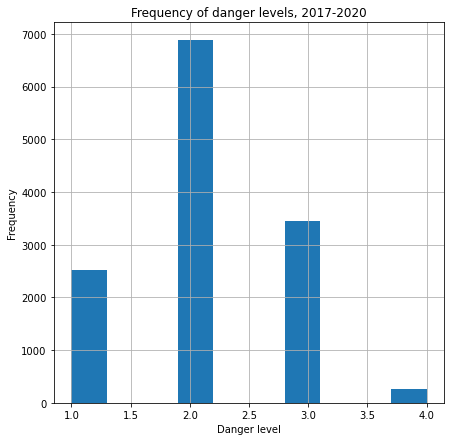

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))
labels['CLASS_danger_level'].hist(ax=ax)

ax.set_xlabel('Danger level')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of danger levels, 2017-2020')
plt.show()

So most of the time the danger level is 1 or 2, although 3 is not uncommon. A danger level of 4 is rare.

Next, we can isolate where the danger level is either 1, 2, 3, or 4 and then use that to select text on those days.

In [12]:
dlevel1_idx = labels.index[np.where(labels['CLASS_danger_level'] == 1)[0]]
dlevel2_idx = labels.index[np.where(labels['CLASS_danger_level'] == 2)[0]]
dlevel3_idx = labels.index[np.where(labels['CLASS_danger_level'] == 3)[0]]
dlevel4_idx = labels.index[np.where(labels['CLASS_danger_level'] == 4)[0]]

In [13]:
# make sure these dates show up in the indexed labels and main text messages
dlevel1_idx

MultiIndex([(3003, '2017-12-02'),
            (3003, '2017-12-03'),
            (3035, '2017-12-03'),
            (3003, '2017-12-04'),
            (3035, '2017-12-04'),
            (3003, '2017-12-05'),
            (3003, '2017-12-06'),
            (3014, '2017-12-12'),
            (3013, '2017-12-14'),
            (3013, '2017-12-15'),
            ...
            (3017, '2021-01-11'),
            (3006, '2021-01-12'),
            (3009, '2021-01-12'),
            (3010, '2021-01-12'),
            (3011, '2021-01-12'),
            (3012, '2021-01-12'),
            (3013, '2021-01-12'),
            (3014, '2021-01-12'),
            (3015, '2021-01-12'),
            (3017, '2021-01-12')],
           names=['region', 'date'], length=2525)

In [14]:
labels.loc[dlevel1_idx]

CLASS_danger_level  CLASS_emergency_warning  \
region date                                                      
3003   2017-12-02                   1                        0   
       2017-12-03                   1                        0   
3035   2017-12-03                   1                        0   
3003   2017-12-04                   1                        0   
3035   2017-12-04                   1                        0   
...                               ...                      ...   
3012   2021-01-12                   1                        0   
3013   2021-01-12                   1                        0   
3014   2021-01-12                   1                        0   
3015   2021-01-12                   1                        0   
3017   2021-01-12                   1                        0   

                   CLASS_problem_1  CLASS_problem_2  CLASS_problem_3  \
region date                                                            
3003   2017-12-02                1                0                0   
       2017-12-03                1                0                0   
3035   2017-12-03                1                0                0   
3003   2017-12-04                1                0                0   
3035   2017-12-04                1                0                0   
...                            ...              ...              ...   
3012   2021-01-12                5                0                0   
3013   2021-01-12                5                0                0   
3014   2021-01-12                5                0                0   
3015   2021-01-12                5                0                0   
3017   2021-01-12                5                0                0   

                   CLASS_problem_amount CLASS_drift-slab_cause  \
region date                                                      
3003   2017-12-02                     1              snowdrift   
       2017-12-03                     1              snowdrift   
3035   2017-12-03                     1               new-snow   
3003   2017-12-04                     1              snowdrift   
3035   2017-12-04                     1               new-snow   
...                                 ...                    ...   
3012   2021-01-12                     1                      0   
3013   2021-01-12                     1                      0   
3014   2021-01-12                     1                      0   
3015   2021-01-12                     1                      0   
3017   2021-01-12                     1                      0   

                   CLASS_drift-slab_dist  CLASS_drift-slab_dsize  \
region date                                                        
3003   2017-12-02                      1                       2   
       2017-12-03                      1                       2   
3035   2017-12-03                      2                       1   
3003   2017-12-04                      1                       2   
3035   2017-12-04                      2                       1   
...                                  ...                     ...   
3012   2021-01-12                      0                       0   
3013   2021-01-12                      0                       0   
3014   2021-01-12                      0                       0   
3015   2021-01-12                      0                       0   
3017   2021-01-12                      0                       0   

                   CLASS_drift-slab_lev_fill  ...  REAL_new-loose_lev_max  \
region date                                   ...                           
3003   2017-12-02                          1  ...                     0.0   
       2017-12-03                          1  ...                     0.0   
3035   2017-12-03                          1  ...                     0.0   
3003   2017-12-04                          1  ...                     0.0   
3035   2017-12-04

In [15]:
# this should only contain one value, in this case '1'
np.unique(labels.loc[dlevel1_idx]['CLASS_danger_level'])

array([1])

In [16]:
text_dlevel1 = main_text.loc[dlevel1_idx]
text_dlevel1

main_text
region date                                                         
3003   2017-12-02  Lite snø og generelt stabile forhold, kun muli...
       2017-12-03  Lite snø og generelt stabile forhold, kun muli...
3035   2017-12-03  Generelt stabile forhold, men vær varsom i bra...
3003   2017-12-04  Lite snø og generelt stabile forhold, kun muli...
3035   2017-12-04  Generelt stabile forhold, men vær varsom i bra...
...                                                              ...
3012   2021-01-12  Generelt stabile forhold, men vær forsiktig i ...
3013   2021-01-12  Stort sett stabile forhold, men vær forsiktig ...
3014   2021-01-12  Generelt stabile forhold. I høyden kan vedvare...
3015   2021-01-12  Generelt stabile forhold. Vær forsiktig i høyd...
3017   2021-01-12  Generelt stabile forhold. Unngå leområder i hø...

[2525 rows x 1 columns]

In [17]:
text_dlevel2 = main_text.loc[dlevel2_idx]
text_dlevel2

,,main_text
region,date,
3007,2017-12-02,Det finnes svake lag i snødekket som kan trigg...
3009,2017-12-02,Det finnes svake lag i snødekket som kan trigg...
3010,2017-12-02,Det finnes svake lag i snødekket som kan trigg...
3011,2017-12-02,Det finnes svake lag i snødekket som kan trigg...
3012,2017-12-02,Det finnes svake lag i snødekket som kan trigg...
...,...,...
3003,2021-01-12,Vær forsiktig i leområder med fokksnø. Det fin...
3007,2021-01-12,Vær forsiktig i terrengformasjoner som har sam...
3016,2021-01-12,Vær varsom i leområder der et vedvarende svakt...


In [18]:
text_dlevel3 = main_text.loc[dlevel3_idx]
text_dlevel3

,,main_text
region,date,
3016,2017-12-02,Vær forsiktig der det ligger fersk fokksnø i h...
3017,2017-12-02,Generelt ustabile forhold. Unngå leområder og ...
3031,2017-12-02,"Krevende skredforhold i fjellet, ferdsel i bra..."
3034,2017-12-02,"Krevende skredforhold i fjellet, ferdsel i bra..."
3014,2017-12-03,Lokalt ustabile forhold. Vær forsiktig i områd...
...,...,...
3031,2021-01-12,Vinden snur og skred kan løses ut i alle himme...
3032,2021-01-12,Vinden snur og det kan løses ut skred i alle h...
3034,2021-01-12,Vinden snur og skred kan løses ut i alle himme...


In [19]:
text_dlevel4 = main_text.loc[dlevel4_idx]
text_dlevel4

main_text
region date                                                         
3031   2017-11-23  Kraftig vind og mye nedbør  vil føre til stor ...
3034   2017-11-23  Kraftig vind og mye nedbør  vil føre til stor ...
       2017-12-05  Mildvêr, vind og mykje nedbør fører til auka s...
3022   2017-12-23  Temperaturstigning og svært mye regn gir stor ...
3023   2017-12-23  Temperaturstigning og svært mye regn gir stor ...
...                                                              ...
       2020-04-15  Stigende temperatur vil sammen med kraftig ned...
3024   2020-04-15  Stigende temperatur vil sammen med kraftig ned...
3027   2020-04-15  Stigende temperatur vil sammen med kraftig ned...
3022   2020-05-20  Unngå all skredterreng fra midt på dagen. Kraf...
3023   2020-05-20  Unngå all skredterreng fra midt på dagen. Kraf...

[269 rows x 1 columns]

Checking the shapes of each dataframe and comparing it to the values in the histogram, these seem correct.

In [20]:
print('There are {} main messages in danger level 1, and {} of them are unique.'.format(len(text_dlevel1), len(np.unique(text_dlevel1))))
print('There are {} main messages in danger level 2, and {} of them are unique.'.format(len(text_dlevel2), len(np.unique(text_dlevel2))))
print('There are {} main messages in danger level 3, and {} of them are unique.'.format(len(text_dlevel3), len(np.unique(text_dlevel3))))
print('There are {} main messages in danger level 4, and {} of them are unique.'.format(len(text_dlevel4), len(np.unique(text_dlevel4))))

There are 2525 main messages in danger level 1, and 655 of them are unique.
There are 6876 main messages in danger level 2, and 2247 of them are unique.
There are 3445 main messages in danger level 3, and 1436 of them are unique.
There are 269 main messages in danger level 4, and 130 of them are unique.


We can already see some patterns in how the main text message is written depending on what the danger level is. Interestingly, many main text messages seem to be used word-for-word more than once, meaning that perhaps there are certain *types* of messages that we can assume are relevant to either danger levels or avalanche problems. I am also guessing that there are many similar messages, many fewer types than the unique number of messages implies (word order is changed, or a few words are different but the meaning is the same).

### Data processing
Some processing steps we might want to take for computing correlations between danger levels and word usage are:
- tokenize long strings into individual words
- lowercase each token
- remove stopwords
- tokenize by word
- remove semantic information
- split contractions for removal
- remove punctuation
- remove stop words
- remove non-alphabetic characters

In [21]:
# you will need to download the stopwords corpora from nltk 
# before moving on in this Notebook
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jakidxav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
stopwords = nltk.corpus.stopwords.words('norwegian')
print(stopwords)

['og', 'i', 'jeg', 'det', 'at', 'en', 'et', 'den', 'til', 'er', 'som', 'på', 'de', 'med', 'han', 'av', 'ikke', 'ikkje', 'der', 'så', 'var', 'meg', 'seg', 'men', 'ett', 'har', 'om', 'vi', 'min', 'mitt', 'ha', 'hadde', 'hun', 'nå', 'over', 'da', 'ved', 'fra', 'du', 'ut', 'sin', 'dem', 'oss', 'opp', 'man', 'kan', 'hans', 'hvor', 'eller', 'hva', 'skal', 'selv', 'sjøl', 'her', 'alle', 'vil', 'bli', 'ble', 'blei', 'blitt', 'kunne', 'inn', 'når', 'være', 'kom', 'noen', 'noe', 'ville', 'dere', 'som', 'deres', 'kun', 'ja', 'etter', 'ned', 'skulle', 'denne', 'for', 'deg', 'si', 'sine', 'sitt', 'mot', 'å', 'meget', 'hvorfor', 'dette', 'disse', 'uten', 'hvordan', 'ingen', 'din', 'ditt', 'blir', 'samme', 'hvilken', 'hvilke', 'sånn', 'inni', 'mellom', 'vår', 'hver', 'hvem', 'vors', 'hvis', 'både', 'bare', 'enn', 'fordi', 'før', 'mange', 'også', 'slik', 'vært', 'være', 'båe', 'begge', 'siden', 'dykk', 'dykkar', 'dei', 'deira', 'deires', 'deim', 'di', 'då', 'eg', 'ein', 'eit', 'eitt', 'elles', 'honom'

In [23]:
punctuation = string.punctuation
print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [24]:
def lower_case(tokens):
    """
    Convert all tokens to lowercase. Assumes that tokenizing has already occurred.
    """
    return [token.lower() for token in tokens]

In [25]:
def remove_stopwords(tokens):
    """
    This method removes NLTK stopwords. Currently, this method works for Norwegian stopwords.
    More work can be done to input a "language" parameter to make it more customizable by language.
    """
    # create stopwords set for Norwegian.
    # this list can be modified in the norwegian.txt file for NLTK, or use this syntax:
    # stopwords.extend(your_list_here)
    stopwords = nltk.corpus.stopwords.words('norwegian')
    return [token for token in tokens if token not in stopwords]

In [26]:
def strip_punctuation(tokens):
    """
    Remove punctuation and replace it with an empty string character.
    Example: can't --> cant, okay? --> okay
    """
    # create punctuation list: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    punctuation = string.punctuation

    # see docs: str.maketrans() will make a table to pass to str.translate()
    table = str.maketrans('', '', string.punctuation)
    return [token.translate(table) for token in tokens]

In [27]:
def remove_numbers(tokens):
    """
    Strip any non-alphabetic characters from a list of tokens.
    """
    return [token for token in tokens if token.isalpha()]

Now we should begin splitting apart the main messages into individual characters for processing. It will be easier to do so if each `main_text` data frame were split into a list.

In [28]:
def process(word_list):
    """
    Customizable method for processing strings, returns list of processed tokens.
    """
    # first, extract string values from an array of strings
    # then create a list of split tokens for each main text string
    # this is the tokenizing step
    token_list = [string[0] for string in word_list]
    token_list = [string.split() for string in token_list]
    to_lowercase = [lower_case(token) for token in token_list]
    no_stopwords = [remove_stopwords(token) for token in to_lowercase]
    no_punctuation = [strip_punctuation(token) for token in no_stopwords]
    no_numbers = [remove_numbers(token) for token in no_punctuation]
    
    return token_list, no_numbers

In [29]:
dlevel1_raw, dlevel1_processed = process(text_dlevel1.values)
dlevel2_raw, dlevel2_processed = process(text_dlevel2.values)
dlevel3_raw, dlevel3_processed = process(text_dlevel3.values)
dlevel4_raw, dlevel4_processed = process(text_dlevel4.values)

In [30]:
dlevel1_raw[0]

['Lite',
 'snø',
 'og',
 'generelt',
 'stabile',
 'forhold,',
 'kun',
 'mulighet',
 'for',
 'å',
 'løse',
 'ut',
 'skred',
 'i',
 'noen',
 'få',
 'leheng',
 'med',
 'fokksnøansamlinger.']

In [31]:
dlevel1_processed[0]

['lite',
 'snø',
 'generelt',
 'stabile',
 'forhold',
 'mulighet',
 'løse',
 'skred',
 'få',
 'leheng',
 'fokksnøansamlinger']

Now we could count the top *n* words, say 25 or some other value of our choosing, for each danger level and then plot that as a histogram.

In [32]:
def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    :param text: The text of tv scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    # nested list to flattened list
    flatten_list = [word for list_ in text for word in list_]
    
    # count words
    word_count = Counter(flatten_list)
    
    # sort words by count
    vocab = sorted(word_count, key=word_count.get, reverse=True)
    
    # create dictionary with unique words as keys, counts as values
    vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}
    
    # now invert the key, value mapping 
    int_to_vocab = {ii:word for word, ii in vocab_to_int.items()}

    # return tuple
    return (vocab, word_count, vocab_to_int, int_to_vocab)

In [33]:
vocab1, word_count1, _, _ = create_lookup_tables(dlevel1_processed)
vocab2, word_count2, _, _ = create_lookup_tables(dlevel2_processed)
vocab3, word_count3, _, _ = create_lookup_tables(dlevel3_processed)
vocab4, word_count4, _, _ = create_lookup_tables(dlevel4_processed)

In [34]:
vocab1

['forhold',
 'generelt',
 'stabile',
 'vær',
 'skred',
 'snø',
 'små',
 'forsiktig',
 'fokksnø',
 'varsom',
 'våte',
 'enkelte',
 'terreng',
 'bratte',
 'fare',
 'bratt',
 'fjellsider',
 'leområder',
 'lite',
 'gunstige',
 'gir',
 'få',
 'fokksnøflak',
 'våt',
 'mindre',
 'myk',
 'løse',
 'husk',
 'stort',
 'sett',
 'lag',
 'snøoverflaten',
 'ustabile',
 'solinnstråling',
 'ellers',
 'store',
 'stein',
 'glideskred',
 'høyden',
 'solutsatte',
 'likevel',
 'terrengfeller',
 'nysnøflak',
 'leheng',
 'litt',
 'forekomme',
 'nysnø',
 'snødekket',
 'pga',
 'ligger',
 'oppstikkende',
 'mulighet',
 'svakt',
 'avstand',
 'heng',
 'områder',
 'konsekvenser',
 'finnes',
 'vedvarende',
 'høye',
 'dagtemperaturer',
 'regionen',
 'ferske',
 'fokksnøansamlinger',
 'påvirkes',
 'mulig',
 'skavler',
 'tynt',
 'farlige',
 'utover',
 'myke',
 'ived',
 'glidesprekker',
 'oppmerksom',
 'lagt',
 'steder',
 'hold',
 'fører',
 'samlet',
 'dagen',
 'fersk',
 'fokksnøen',
 'utløste',
 'påvirke',
 'naturlig',
 

In [35]:
word_count1

Counter({'lite': 355,
         'snø': 639,
         'generelt': 1752,
         'stabile': 1488,
         'forhold': 1859,
         'mulighet': 144,
         'løse': 254,
         'skred': 1012,
         'få': 334,
         'leheng': 172,
         'fokksnøansamlinger': 118,
         'vær': 1145,
         'varsom': 515,
         'bratt': 393,
         'terreng': 426,
         'vinden': 72,
         'lagt': 92,
         'ferske': 124,
         'fokksnøflak': 322,
         'likevel': 183,
         'forsiktig': 523,
         'fokksnøen': 79,
         'myk': 279,
         'finnes': 135,
         'kantkornlag': 14,
         'nede': 6,
         'snødekket': 154,
         'nå': 3,
         'vedvarande': 46,
         'svakt': 144,
         'lag': 226,
         'bakken': 25,
         'påverkast': 21,
         'tynt': 112,
         'hard': 18,
         'snøoverflate': 13,
         'områder': 140,
         'kommer': 18,
         'nedbør': 19,
         'enkelte': 455,
         'leformasjoner': 20,
 

In [36]:
def top_n_words(vocab, word_count, n):
    """
    Return the top *n* words given a list of words and their 
    frequencies as a dictionary.
    """
    top_words = vocab[:n]
    top_counts = [word_count[word] for word in top_words]
    return top_words, top_counts

In [37]:
n = 25
top_words1, top_counts1 = top_n_words(vocab1, word_count1, n)
top_words2, top_counts2 = top_n_words(vocab2, word_count2, n)
top_words3, top_counts3 = top_n_words(vocab3, word_count3, n)
top_words4, top_counts4 = top_n_words(vocab4, word_count4, n)

In [38]:
def plot_top_word_counts(top_words, top_counts, danger_level):
    fig, ax = plt.subplots(figsize=(7, 7))

    ax.barh(top_words[::-1], top_counts[::-1])

    ax.set_xlabel('Frequency')
    ax.set_ylabel('Word')
    ax.set_title('Top word counts for danger level {}, 2017-2020'.format(danger_level))

    plt.show()

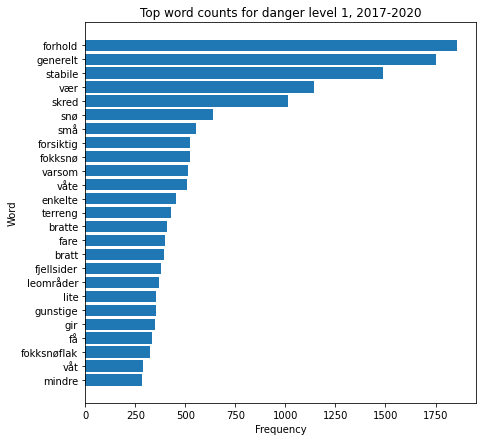

In [39]:
plot_top_word_counts(top_words1, top_counts1, 1)

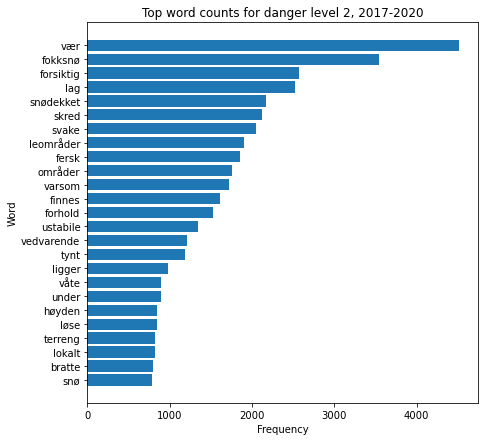

In [40]:
plot_top_word_counts(top_words2, top_counts2, 2)

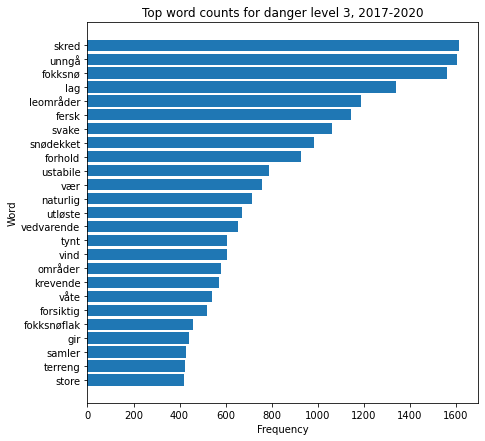

In [41]:
plot_top_word_counts(top_words3, top_counts3, 3)

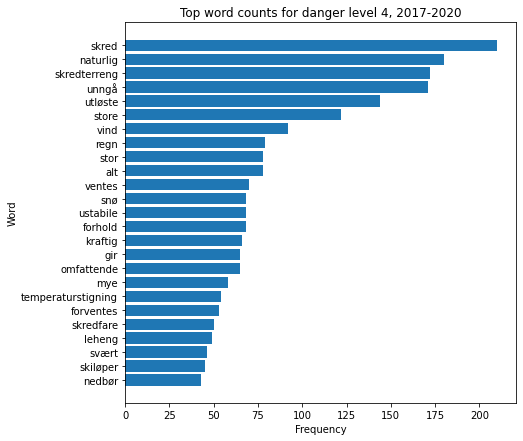

In [42]:
plot_top_word_counts(top_words4, top_counts4, 4)

**I will need to look at how to reduce which words are included here. For example, vær is included as is skred, both of which you might expect from something written on an avalanche bulletin. Maybe running correlations will yield better results, but I suspect I will have to do more reduce the types of words in each danger level list.**

However, it is encouraging that as we progress up in danger level, words like:
- skred
- ustabile
- kraftig
- store
- utløste
- forsiktig
- etc.

also increase in frequency.

## Avalanche problem 1

In [43]:
np.unique(labels['CLASS_problem_1'])

array([0, 1, 2, 3, 4, 5, 6, 7])

In [44]:
prob0_idx = labels.index[np.where(labels['CLASS_problem_1'] == 0)[0]]
prob1_idx = labels.index[np.where(labels['CLASS_problem_1'] == 1)[0]]
prob2_idx = labels.index[np.where(labels['CLASS_problem_1'] == 2)[0]]
prob3_idx = labels.index[np.where(labels['CLASS_problem_1'] == 3)[0]]
prob4_idx = labels.index[np.where(labels['CLASS_problem_1'] == 4)[0]]
prob5_idx = labels.index[np.where(labels['CLASS_problem_1'] == 5)[0]]
prob6_idx = labels.index[np.where(labels['CLASS_problem_1'] == 6)[0]]
prob7_idx = labels.index[np.where(labels['CLASS_problem_1'] == 7)[0]]

In [45]:
prob0_idx

MultiIndex([(3016, '2017-12-15'),
            (3017, '2017-12-16'),
            (3014, '2018-02-02'),
            (3017, '2018-02-02'),
            (3014, '2018-02-03'),
            (3014, '2018-02-04'),
            (3037, '2018-02-12'),
            (3037, '2018-02-16'),
            (3006, '2018-03-02'),
            (3006, '2018-03-28'),
            (3006, '2018-04-01'),
            (3014, '2018-05-17'),
            (3014, '2018-05-18'),
            (3014, '2018-05-19'),
            (3014, '2018-05-20'),
            (3022, '2018-12-02'),
            (3023, '2018-12-02'),
            (3031, '2018-12-23'),
            (3024, '2019-02-27'),
            (3037, '2019-05-17'),
            (3037, '2019-05-18'),
            (3037, '2019-05-19'),
            (3037, '2019-05-20'),
            (3037, '2019-05-21'),
            (3037, '2019-05-22'),
            (3037, '2019-05-23'),
            (3037, '2019-05-24'),
            (3037, '2019-05-25')],
           names=['region', 'date'])

In [46]:
# this should only contain one value, in this case '0'
np.unique(labels.loc[prob0_idx]['CLASS_problem_1'])

array([0])

In [47]:
main_text.loc[prob0_idx]

main_text
region date                                                         
3016   2017-12-15  Generelt ganske stabile forhold, men vær forsi...
3017   2017-12-16  Generelt ganske stabile forhold, men vær forsi...
3014   2018-02-02  Generelt stabile forhold. Snøoverflaten er har...
3017   2018-02-02                         Generelt stabile forhold. 
3014   2018-02-03                         Generelt stabile forhold. 
       2018-02-04                         Generelt stabile forhold. 
3037   2018-02-12                                                   
       2018-02-16                                                   
3006   2018-03-02                                                   
       2018-03-28                                                   
       2018-04-01                                                   
3014   2018-05-17  Generelt stabile forhold. Vær varsom nært terr...
       2018-05-18  Generelt stabile forhold. Vær varsom nært terr...
       2018-05-19  Generelt stabile forhold. Vær varsom nært terr...
       2018-05-20  Generelt stabile forhold. Vær varsom nært terr...
3022   2018-12-02  Det er lite eller ingen snø, og liten skredfar...
3023   2018-12-02  Det er lite eller ingen snø, og liten skredfar...
3031   2018-12-23  Vær forsiktig i leområder som har samlet fokks...
3024   2019-02-27  Snø og sterk vind vil utover dagen gi ferske f...
3037   2019-05-17       Det er lite snø og generelt stabile forhold.
       2019-05-18               Det er lite snø, og liten skredfare.
       2019-05-19               Det er lite snø, og liten skredfare.
       2019-05-20               Det er lite snø, og liten skredfare.
       2019-05-21               Det er lite snø, og liten skredfare.
       2019-05-22               Det er lite snø, og liten skredfare.
       2019-05-23               Det er lite snø, og liten skredfare.
       2019-05-24               Det er lite snø, og liten skredfare.
       2019-05-25               Det er lite snø, og liten skredfare.

In [48]:
text_prob0 = main_text.loc[prob0_idx]
text_prob1 = main_text.loc[prob1_idx]
text_prob2 = main_text.loc[prob2_idx]
text_prob3 = main_text.loc[prob3_idx]
text_prob4 = main_text.loc[prob4_idx]
text_prob5 = main_text.loc[prob5_idx]
text_prob6 = main_text.loc[prob6_idx]
text_prob7 = main_text.loc[prob7_idx]

In [49]:
print('There are {} main messages for avalanche problem 0, and {} of them are unique.'.format(len(text_prob0), len(np.unique(text_prob0))))
print('There are {} main messages for avalanche problem 1, and {} of them are unique.'.format(len(text_prob1), len(np.unique(text_prob1))))
print('There are {} main messages for avalanche problem 2, and {} of them are unique.'.format(len(text_prob2), len(np.unique(text_prob2))))
print('There are {} main messages for avalanche problem 3, and {} of them are unique.'.format(len(text_prob3), len(np.unique(text_prob3))))
print('There are {} main messages for avalanche problem 4, and {} of them are unique.'.format(len(text_prob4), len(np.unique(text_prob4))))
print('There are {} main messages for avalanche problem 5, and {} of them are unique.'.format(len(text_prob5), len(np.unique(text_prob5))))
print('There are {} main messages for avalanche problem 6, and {} of them are unique.'.format(len(text_prob6), len(np.unique(text_prob6))))
print('There are {} main messages for avalanche problem 7, and {} of them are unique.'.format(len(text_prob7), len(np.unique(text_prob7))))

There are 28 main messages for avalanche problem 0, and 11 of them are unique.
There are 6526 main messages for avalanche problem 1, and 2176 of them are unique.
There are 214 main messages for avalanche problem 2, and 76 of them are unique.
There are 16 main messages for avalanche problem 3, and 9 of them are unique.
There are 1715 main messages for avalanche problem 4, and 684 of them are unique.
There are 1749 main messages for avalanche problem 5, and 673 of them are unique.
There are 2169 main messages for avalanche problem 6, and 663 of them are unique.
There are 698 main messages for avalanche problem 7, and 331 of them are unique.


So there is an imbalance in how many times each avalanche problem occurs in `CLASS_problem_1` in the avalanche bulletin. Still, in each case, the number of unique messages is << than the total number of messages written.